# Tuango - RFM Analysis for Mobile App Push Messaging

A recency-frequency-monetary (RFM) model uses a customer's past purchasing behaviour (metrics of days since last purchase, frequency of purchases and money spent) to target future marketing efforts only at those customers who are most likely to make a purchase and thus maximize return on the marketing expenditure.

## Goal

Tuango is a company in China offering deals on products and services (like Groupon). They are interested in a RFM approach on who to target out of their customer base of 278780 people, to give 3 Karaoke deals priced at 129RMB, 209RMB and 259RMB. Calculate expected profit and return on marketing expenditure (ROME) of 5 variants of RFM approaches compared to a baseline method where customers are not targeted.


## The Data
(courtesy Vincent Nijs - Rady School of Management - University of California San Diego)

:: Tuango's fee was 50% of the deal price <br>
:: Tuango has determined that the cost of SMS-ing the deals to a single customer is 2.5RMB, which was estimated by a drop in customer lifetime value times the probabality of a customer blocking a deal message (i.e., customer annoyance on seeing a deal message and its associated impact on the lifetime value of that customer) <br>

In [16]:
import numpy as np
import pandas as pd
import pyrsm as rsm
import seaborn as sns

tuango = pd.read_pickle("data/tuango.pkl")

tuango

,userid,recency,frequency,monetary,rfm_iq_pre,buyer,ordersize,platform,category,mobile_os
0,U12617430,309,7,39.80,514,no,0.0,App,3,android
1,U63302737,297,8,39.80,514,no,0.0,Browser,3,android
2,U77095928,295,1,72.90,553,no,0.0,Browser,3,android
3,U43509181,277,1,40.00,554,no,0.0,Browser,3,android
4,U23195941,259,1,21.00,555,no,0.0,App,3,android
...,...,...,...,...,...,...,...,...,...,...
27873,U63704968,14,3,78.00,243,no,0.0,App,18,android
27874,U87740670,14,4,19.80,235,no,0.0,App,18,android
27875,U79814710,11,4,171.20,132,no,0.0,App,19,android
27876,U86467655,11,4,171.20,132,yes,209.0,App,19,android


## Methodology

:- Use a training sample set of 10% of the customer base (27878 people), to determine who would be targeted by the RFM method <br>
:- Calculate projected profit on remaining 90% based on response observed in 10% training sample, comparing to 'non targeted/message everybody' approach <br>
:- Calculate actual profit based on the response observed on the 90% test sample and compare to prediction <br>

## Descriptive Analysis

#### Percentage of customers who responded (i.e., bought anything) after the push message:

In [123]:
res = np.mean(tuango.buyer == "yes")
f""" {round((100*res), 3)}% of the sampled customers responded by making a purchase after the push message"""

' 2.981% of the sampled customers responded by making a purchase after the push message'

#### Average amount spent on the Karaoke deal by customers that bought one (or more):

In [124]:
res = np.mean(tuango[tuango.buyer == "yes"]["ordersize"])

f""" Among the sampled customers, amount spent per customer (average) on the deal was  RMB {round(res, 2)}"""

' Among the sampled customers, amount spent per customer (average) on the deal was  RMB 202.13'

#### 	Creating independent quintile variables for recency, frequency and monetary and assessing the 3 variables are not highly corrrelated: 

In [125]:
tuango = tuango.assign(rec_iq=rsm.xtile(tuango["recency"], 5))
tuango = tuango.assign(freq_iq=rsm.xtile(tuango["frequency"], 5, rev=True))
tuango = tuango.assign(mon_iq=rsm.xtile(tuango["monetary"], 5, rev=True))

# Number of customer per bin

pd.DataFrame(
    {
        "#cust_rec_iq": tuango["rec_iq"].value_counts(),
        "#cust_freq_iq": tuango["freq_iq"].value_counts(),
        "#cust_mon_iq": tuango["mon_iq"].value_counts(),
    }
)

# Correlation between RFM Variables: to check if all 3 feature variables are necessary to be included in model

tuango[["recency", "frequency", "monetary"]].corr().round(3)

tuango[["rec_iq", "freq_iq", "mon_iq"]].corr().round(3)

,rec_iq,freq_iq,mon_iq
rec_iq,1.000,-0.026,-0.092
freq_iq,-0.026,1.000,0.049
mon_iq,-0.092,0.049,1.000


#### 	Bar charts showing the response rate (i.e., the proportion of customers who bought something) for this deal per (independent) recency, frequency, and monetary quintile

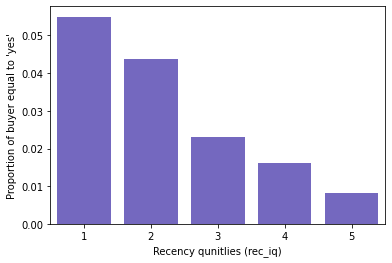

In [8]:
graph_rec_iq = rsm.prop_plot(tuango, "rec_iq", "buyer", "yes")

graph_rec_iq = graph_rec_iq.set(xlabel="Recency qunitlies (rec_iq)")

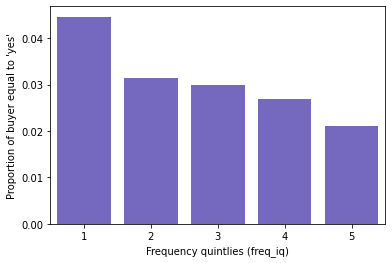

In [9]:
graph_freq_iq = rsm.prop_plot(tuango, "freq_iq", "buyer", "yes")

graph_freq_iq = graph_freq_iq.set(xlabel="Frequency quintlies (freq_iq)")

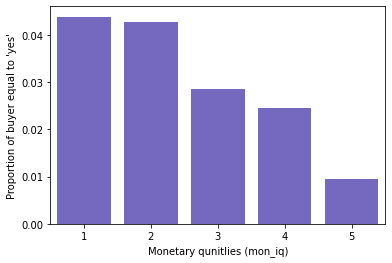

In [10]:
graph_mon_iq = rsm.prop_plot(tuango, "mon_iq", "buyer", "yes")

graph_mon_iq = graph_mon_iq.set(xlabel="Monetary qunitlies (mon_iq)")

## Profitability Analysis

#### Breakeven response rate 

In [17]:
Exp_prof_percust = 0.5 * np.mean(tuango[tuango.buyer == "yes"]["ordersize"])

Marg_cost_percust = 2.5

brk_even_rate = Marg_cost_percust / Exp_prof_percust

print(f"""Likelihood of making a purchase upon seeing message (aka break even response rate) has to be > (cost of messaging deal / expected profit per customer)""") 
print('\n',f"""Breakeven response rate is {round(100*brk_even_rate, 3)}%""")

Likelihood of making a purchase upon seeing message (aka break even response rate) has to be > (cost of messaging deal / expected profit per customer)

 Breakeven response rate is 2.474%


### Comparison of approaches

1.) No targeting /message everybody approach <br>
2.) RFM with independent quintiles (people are categorised on the 3 variables (recency, frequency, monetary) independently on the 1-5 scale, where 1:best, 5:worst) <br>
3.) RFM with sequential quintiles (within the people in each quintile of the first variable (Recency), binning takes place wrt. the second variable (frequency) and the same goes with monetary <br>
4.) RFM with sequential quintiles with a specific breakeven response rate applied to each bin based on bin's average spending <br>
5.) Conservative estimate on independent quintiles <br>
6.) Conservative estimate on sequential quintiles

In [127]:
# no targeting/everybody gets messaged approach:

sample_resp = pd.DataFrame(
    {
        "n_obs": tuango["buyer"].value_counts(),
        "resp": tuango.groupby("buyer")["buyer"]
        .agg("count")
        .agg(lambda x: x / x.sum()),
    }
)

Proj_Profit = (
    250902 * sample_resp.loc["yes", "resp"] * Exp_prof_percust
    - 250902 * Marg_cost_percust
)

ROME = Proj_Profit / (250902 * Marg_cost_percust)

In [128]:
# function definition for the other 5 methods

tuango = pd.read_pickle("data/tuango.pkl")

def perf_calc(
    method="iq",
    tuango=tuango,
    Exp_prof_percust=Exp_prof_percust,
    Marg_cost_percust=Marg_cost_percust,
    brk_even_rate="avg",
    cons_est="no",
):

    if method == "iq":

        tuango = tuango.assign(rec=rsm.xtile(tuango["recency"], 5))
        tuango = tuango.assign(freq=rsm.xtile(tuango["frequency"], 5, rev=True))
        tuango = tuango.assign(mon=rsm.xtile(tuango["monetary"], 5, rev=True))
        tuango = tuango.assign(
            rfm=tuango.rec.astype(str)
            + tuango.freq.astype(str)
            + tuango.mon.astype(str)
        )

    elif method == "sq":

        tuango = tuango.assign(rec=rsm.xtile(tuango["recency"], 5))
        tuango = tuango.assign(
            freq=tuango.groupby("rec")["frequency"].transform(rsm.xtile, 5, rev=True)
        )
        tuango = tuango.assign(
            mon=tuango.groupby(["rec", "freq"])["monetary"].transform(
                rsm.xtile, 5, rev=True
            )
        )
        tuango = tuango.assign(
            rfm=tuango.rec.astype(str)
            + tuango.freq.astype(str)
            + tuango.mon.astype(str)
        )

    if cons_est == "no":
        prop_series = tuango.groupby("rfm")["buyer"].transform(
            lambda x: np.nanmean(x == "yes")
        )

    elif cons_est == "yes":
        prop_series = tuango.groupby("rfm")["buyer"].transform(
            lambda x: np.nanmean(x == "yes") - 1.64 * rsm.seprop(x == "yes")
        )

    if brk_even_rate == "avg":

        brk_even_rate = Marg_cost_percust / Exp_prof_percust

        tuango = tuango.assign(
            rfm_resp=prop_series, mailto=(prop_series > brk_even_rate).astype(str)
        )

    elif brk_even_rate == "indv":

        # for those RFM_index groups, where no buyers made a purchase, that break even rate was coded as 0 and those customers were not selected to be mailed.
        # Rationale: those RFM groups are not likely to generate revenue if targeted.

        tuango["buyer_dummy"] = rsm.ifelse(tuango["buyer"] == "yes", 1, 0)
        temp = tuango.groupby("rfm_iq_pre")[["ordersize", "buyer_dummy"]].transform(sum)
        temp["avg"] = Marg_cost_percust / (
            0.5 * (temp["ordersize"] / temp["buyer_dummy"])
        )
        temp = temp.fillna(0)

        tuango = tuango.assign(
            rfm_resp=prop_series, mailto=(prop_series > temp["avg"]).astype(str)
        )

    nmail = pd.DataFrame()
    nmail["n_obs"] = tuango["mailto"].value_counts()
    nmail["perc"] = (
        tuango.groupby("mailto")["mailto"].agg("count").agg(lambda x: x / x.sum())
    )

    resp = pd.DataFrame()
    resp["n_obs"] = tuango["mailto"].value_counts()
    resp["n_buyers"] = (
        tuango[tuango.buyer == "yes"].groupby("mailto")["buyer"].agg("count")
    )
    resp["perc"] = np.array(resp["n_buyers"]) / np.array(resp["n_obs"])

    Exp_Profit = (
        250902 * nmail.loc["True", "perc"] * resp.perc[1] * Exp_prof_percust
        - 250902 * nmail.loc["True", "perc"] * Marg_cost_percust
    )

    ROME = Exp_Profit / (Marg_cost_percust * 250902 * nmail.loc["True", "perc"])

    return Exp_Profit, ROME, tuango

In [129]:
res1 = perf_calc(
    method="iq",
    tuango=tuango,
    Exp_prof_percust=Exp_prof_percust,
    Marg_cost_percust=Marg_cost_percust,
    brk_even_rate="avg",
    cons_est="no",
)
res2 = perf_calc(
    method="sq",
    tuango=tuango,
    Exp_prof_percust=Exp_prof_percust,
    Marg_cost_percust=Marg_cost_percust,
    brk_even_rate="avg",
    cons_est="no",
)
res3 = perf_calc(
    method="sq",
    tuango=tuango,
    Exp_prof_percust=Exp_prof_percust,
    Marg_cost_percust=Marg_cost_percust,
    brk_even_rate="indv",
    cons_est="no",
)
res4 = perf_calc(
    method="iq",
    tuango=tuango,
    Exp_prof_percust=Exp_prof_percust,
    Marg_cost_percust=Marg_cost_percust,
    brk_even_rate="avg",
    cons_est="yes",
)
res5 = perf_calc(
    method="sq",
    tuango=tuango,
    Exp_prof_percust=Exp_prof_percust,
    Marg_cost_percust=Marg_cost_percust,
    brk_even_rate="avg",
    cons_est="yes",
)

df = pd.DataFrame(
    {
        "Expected_profit_RMB": [
            Proj_Profit,
            res1[0],
            res2[0],
            res3[0],
            res4[0],
            res5[0],
        ],
        "ROME": [ROME, res1[1], res2[1], res3[1], res4[1], res5[1]],
        "Models": [
            "No targeting",
            "Indep. Quintile",
            "Seq. Quintile",
            "Seq. Quint w. indv. brk_resp",
            "Indep. Quintile_conservative",
            "Seq. Quintile_conservative",
        ],
    }
)

df

,Expected_profit_RMB,ROME,Models
0,128605.500000,0.205029,No targeting
1,331967.371841,1.188697,Indep. Quintile
2,336439.521661,1.297316,Seq. Quintile
3,324655.759928,1.185535,Seq. Quint w. indv. brk_resp
4,280372.375451,2.058308,Indep. Quintile_conservative
5,279385.272563,1.970972,Seq. Quintile_conservative


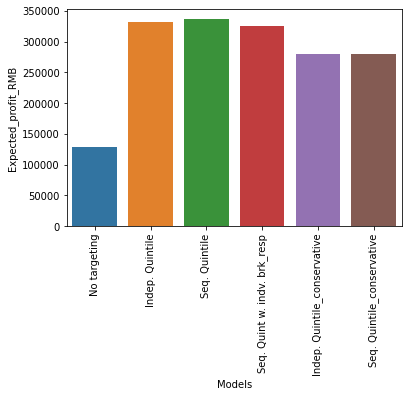

In [111]:
plot = sns.barplot(x=df.Models, y=df.Expected_profit_RMB, ci=None, data=df)
a = plot.get_xticklabels()
for i in a:
    i.set_rotation(90)

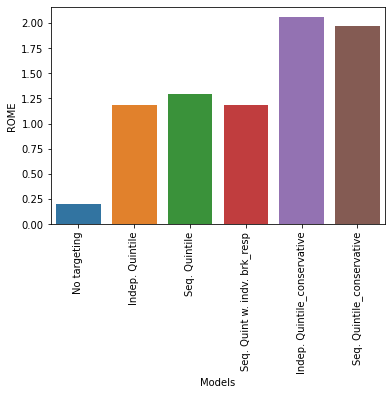

In [112]:
plot = sns.barplot(x=df.Models, y=df.ROME, ci=None, data=df)
a = plot.get_xticklabels()
for i in a:
    i.set_rotation(90)

### Performance of model against actual results

In [131]:
tuango_post = pd.read_pickle("data/tuango_post.pkl")

# Focusing analyses on remaining 250902 customers:

tuango = tuango_post[tuango_post["training"] == 0]

In [132]:
indep_quintile = res1[2]['rfm'][res1[2].mailto == 'True']
seq_quintile = res2[2]['rfm'][res2[2].mailto == 'True']
seq_quintile_indv_brk_resp = res3[2]['rfm'][res3[2].mailto == 'True']
indep_quintile_conservative = res4[2]['rfm'][res4[2].mailto == 'True']
seq_quintile_conservative = res5[2]['rfm'][res5[2].mailto == 'True']

In [133]:
# Actual revenue from remaining 250902 customers, no targeting

Actual_Profit = 0.5 * sum(tuango["ordersize"]) - len(tuango) * Marg_cost_percust

Actual_ROME = Actual_Profit / (len(tuango) * Marg_cost_percust)

In [134]:
def perf_actual(method, tuango, target_id, Marg_cost_percust):
    
    tuango = tuango[tuango["training"] == 0]
    
    if method == "iq":

        tuango = tuango.assign(rec=rsm.xtile(tuango["recency"], 5))
        tuango = tuango.assign(freq=rsm.xtile(tuango["frequency"], 5, rev=True))
        tuango = tuango.assign(mon=rsm.xtile(tuango["monetary"], 5, rev=True))
        tuango = tuango.assign(
            rfm=tuango.rec.astype(str)
            + tuango.freq.astype(str)
            + tuango.mon.astype(str)
        )

    elif method == "sq":

        tuango = tuango.assign(rec=rsm.xtile(tuango["recency"], 5))
        tuango = tuango.assign(
            freq=tuango.groupby("rec")["frequency"].transform(rsm.xtile, 5, rev=True)
        )
        tuango = tuango.assign(
            mon=tuango.groupby(["rec", "freq"])["monetary"].transform(
                rsm.xtile, 5, rev=True
            )
        )
        tuango = tuango.assign(
            rfm=tuango.rec.astype(str)
            + tuango.freq.astype(str)
            + tuango.mon.astype(str)
        )
    
    tuango["mailto"] = rsm.ifelse(tuango["rfm"].isin(target_id), "True", "False")

    Actual_Profit = (
        0.5 * sum(tuango[tuango["mailto"] == "True"]["ordersize"])
        - len(tuango[tuango["mailto"] == "True"]) * Marg_cost_percust
    )

    Actual_ROME = Actual_Profit / (
        len(tuango[tuango["mailto"] == "True"]) * Marg_cost_percust
    )

    return Actual_Profit, Actual_ROME, tuango

In [135]:
res1 = perf_actual(
    method="iq",
    tuango=tuango_post,
    target_id=indep_quintile,
    Marg_cost_percust=Marg_cost_percust,
)
res2 = perf_actual(
    method="sq",
    tuango=tuango_post,
    target_id=seq_quintile,
    Marg_cost_percust=Marg_cost_percust,
)
res3 = perf_actual(
    method="sq",
    tuango=tuango_post,
    target_id=seq_quintile_indv_brk_resp,
    Marg_cost_percust=Marg_cost_percust,

)
res4 = perf_actual(
    method="iq",
    tuango=tuango_post,
    target_id=indep_quintile_conservative,
    Marg_cost_percust=Marg_cost_percust,

)
res5 = perf_actual(
    method="sq",
    tuango=tuango_post,
    target_id=seq_quintile_conservative,
    Marg_cost_percust=Marg_cost_percust,

)


df = pd.DataFrame(
    {
        "Actual_profit_RMB": [
            Actual_Profit,
            res1[0],
            res2[0],
            res3[0],
            res4[0],
            res5[0],
        ],
        "ROME": [Actual_ROME, res1[1], res2[1], res3[1], res4[1], res5[1]],
        "Models": [
            "No targeting",
            "Indep. Quintile",
            "Seq. Quintile",
            "Seq. Quint w. indv. brk_resp",
            "Indep. Quintile_conservative",
            "Seq. Quintile_conservative",
        ],
    }
)

df

,Actual_profit_RMB,ROME,Models
0,124492.5,0.198472,No targeting
1,330636.0,1.184481,Indep. Quintile
2,341348.0,1.320265,Seq. Quintile
3,314344.0,1.017649,Seq. Quint w. indv. brk_resp
4,285943.0,2.100784,Indep. Quintile_conservative
5,283871.5,2.015453,Seq. Quintile_conservative


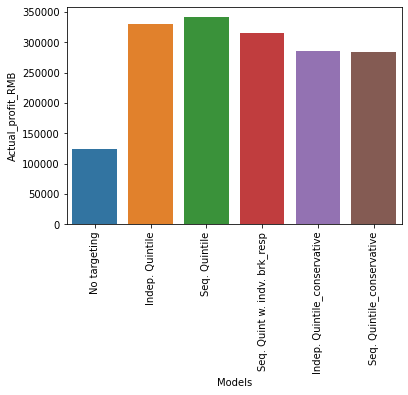

In [136]:
plot = sns.barplot(x=df.Models, y=df.Actual_profit_RMB, ci=None, data=df)
a = plot.get_xticklabels()
for i in a:
    i.set_rotation(90)

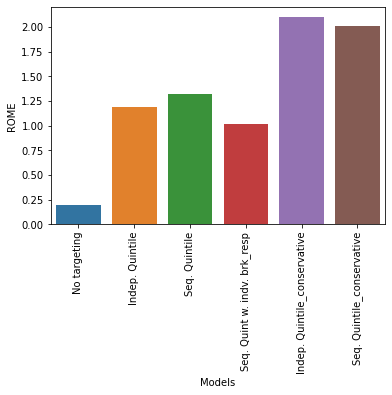

In [137]:
plot = sns.barplot(x=df.Models, y=df.ROME, ci=None, data=df)
a = plot.get_xticklabels()
for i in a:
    i.set_rotation(90)

### Summary

Sequential method is preferable for the equitable distribution of customers in every bin over the independent quantile method which normally results in not all bins receiving similar number of people.

Because there is a standard error associated with the response rate calculated from the sample, a conservative response rate was evaluated (lower bound of a one sided 95% CI) when reporting out projected profits and ROME.

Projected profits and ROME match well to the actual profits and ROME from the purchasing behaviour actually displayed by the 250902 customers.